In [1]:
#import geopandas as gpd
#import shapefile
#import fiona
import numpy as np
#import geopandas as gpd
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import xarray as xr


In [2]:
#---
# get lat/lon of AGI mesh
#---
from pathlib import Path

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list
habitat_all = np.zeros([360,1440,no_species])

habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat  = ff['lat'].values 
        lon  = ff['lon'].values 
    ff.close()
    
lat2,lon2 = np.meshgrid(lat,lon)
print(np.min(lon2),np.max(lon2))


-179.875 179.875


In [6]:
#---
# CCAMLR regions
#---
# construct the mask without shapefile but based on lat/lon limits
# see e.g. map here: https://www.mdpi.com/2071-1050/13/17/9770

#res = 0.1
#lon = np.arange(-180,180+res,res) # np.arange(-179.5,179.5+res,res) # ds.lon
#lat = np.arange(-90,-40+res,res) #np.arange(-89.5,-39.5+res,res) # ds.lat

res1 = 0.25
res2 = 0.125
lon = np.arange(-180,180,res1) # np.arange(-179.5,179.5+res,res) # ds.lon
lat = np.arange(-90,-45,res2) #np.arange(-89.5,-39.5+res,res) # ds.lat

#lon = np.arange(-180,180+res1,res1) # np.arange(-179.5,179.5+res,res) # ds.lon
#lat = np.arange(-90,-45+res2,res2) #np.arange(-89.5,-39.5+res,res) # ds.lat

#res = 0.1 
#xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
#yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude



# area 48
# south of 50S between 50W and 30E
# south of 60S between 70W and 50W

# area 58
# south of 45S between 30E and 80E
# south of 55S between 80E and 150E

# area 88
# south of 60S between 150E and 70W

mask48 = np.nan*np.ones_like(lon2)
mask58 = np.nan*np.ones_like(lon2)
mask88 = np.nan*np.ones_like(lon2)

# area 48
ind = np.where((lon2<30) & (lon2>=-50) & (lat2<=-50))
mask48[ind] = 1
del ind
ind = np.where((lon2<-50) & (lon2>=-70) & (lat2<=-60))
mask48[ind] = 1
del ind

# area 58
ind = np.where((lon2<80) & (lon2>=30) & (lat2<=-45))
mask58[ind] = 1
del ind
ind = np.where((lon2<150) & (lon2>=80) & (lat2<=-55))
mask58[ind] = 1
del ind

# area 88
ind = np.where(((lon2<-70) | (lon2>=150)) & (lat2<=-60))
mask88[ind] = 1
del ind

print('done')


done


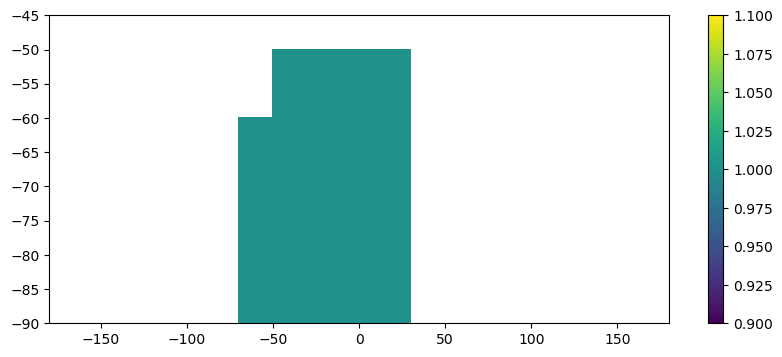

[ 1. nan]


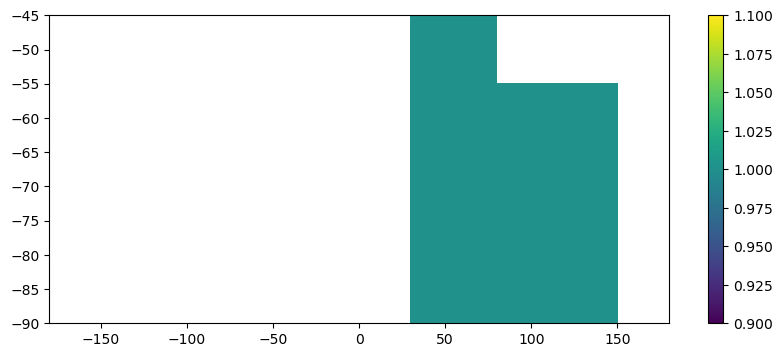

[ 1. nan]


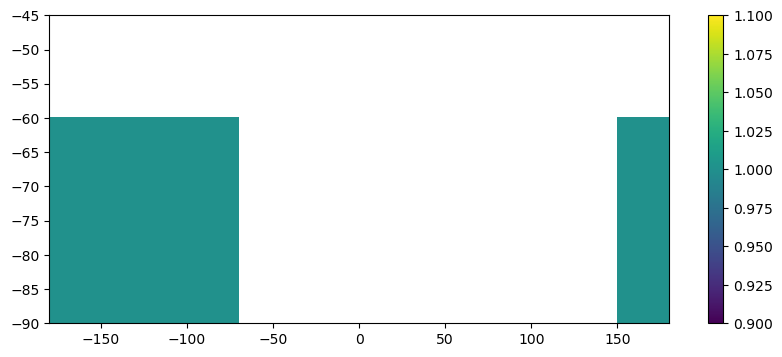

[ 1. nan]


In [8]:
test_plot = True
if test_plot: 
    fig=plt.figure(figsize=(10,4))
    plt.pcolor(lon2,lat2,mask48)#.transpose())
    plt.colorbar()
    plt.show()
    print(np.unique(mask48))
    
    fig=plt.figure(figsize=(10,4))
    plt.pcolor(lon2,lat2,mask58)#.transpose())
    plt.colorbar()
    plt.show()
    print(np.unique(mask48))
    
    fig=plt.figure(figsize=(10,4))
    plt.pcolor(lon2,lat2,mask88)#.transpose())
    plt.colorbar()
    plt.show()
    print(np.unique(mask48))
    

In [10]:
#---------
# SAVE SUBAREA AVERAGES AS NETCDF FILE
#---------

import os

save_netcdf = True
if save_netcdf: 
    # save to netcdf file
    
    saving_directory  = '/pscratch/sd/c/cnissen/shape_files/ccamlr_areas/' 
    
    mpa_list = ['area48','area58','area88']
    
    #if res==0.5:
    #    res_string = '0.5deg'
    #elif res==1.0:
    #    res_string = '1deg'
    #elif res==0.1:
    #    res_string = '0.1deg'
        
        
    for rr in range(0,len(mpa_list)):
        print (mpa_list[rr]+'...')
        netcdf_name       = 'CCAMLR_mask_'+mpa_list[rr]+'_regular_mesh_AGI_mesh.nc' 
        #netcdf_name       = 'CCAMLR_mask_'+mpa_list[rr]+'_regular_mesh_'+res_string+'.nc' 
        if mpa_list[rr] in ['area48']:
            data1 = mask48
        elif mpa_list[rr] in ['area58']:
            data1 = mask58
        elif mpa_list[rr] in ['area88']:
            data1 = mask88
            
        fv=-999
        data1[np.isnan(data1)]=fv
        
        if save_netcdf: 
            # add a statement to only do the below if file does not yet exist.
            if not os.path.exists(saving_directory+netcdf_name):
                print ('Create file '+saving_directory+netcdf_name)
                w_nc_fid = Dataset(saving_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')

                w_nc_fid.resolution_lon = res1
                w_nc_fid.resolution_lat = res2
                #w_nc_fid.resolution = res_string
                w_nc_fid.script = '/global/homes/c/cnissen/scripts/save_ccamlr_regions_on_regular_grid_no_shape_files.ipynb'

                # create dimension & variable
                w_nc_fid.createDimension('lat', len(lat)) 
                w_nc_fid.createDimension('lon', len(lon)) 
                w_nc_fid.createVariable('lon', 'f4',('lon'))
                w_nc_fid.createVariable('lat', 'f4',('lat'))
                w_nc_fid.variables['lon'][:] = lon
                w_nc_fid.variables['lat'][:] = lat
                w_nc_var1 = w_nc_fid.createVariable('mask_area', 'f4',('lat','lon'),fill_value=fv)
                w_nc_var1.description = 'Mask for CCAMLR '+mpa_list[rr]+' (1 if in area)'
                w_nc_fid.close()

        if save_netcdf: 
            w_nc_fid = Dataset(saving_directory+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
            w_nc_fid.variables['mask_area'][:,:] = data1.transpose()
            w_nc_fid.close()  
        del data1
        
print('done')


area48...
Create file /pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area48_regular_mesh_AGI_mesh.nc
area58...
Create file /pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area58_regular_mesh_AGI_mesh.nc
area88...
Create file /pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area88_regular_mesh_AGI_mesh.nc
done


In [ ]:
print(mask48.shape,lon.shape,lat.shape,np.min(lat),np.max(lat))
